### Подготовка к IF

## TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.95,
    token_pattern=r"(?u)\b\w+\b",
)

X = vectorizer.fit_transform(df_blocks["tokenized_block"])
print("TF-IDF:", X.shape)

TF-IDF: (575061, 311)


## Isolation Forest

| Гиперпараметр | Что делает | Значение |
|----------|--------------|------------|
| n_estimators | Количество деревьев в лесу |   100|
| max_samples | Количество случайных выборок для каждого дерева |100_000|
| contamination |Ожидаемая доля аномалий| auto|

```
Ключевая идея Isolation Forest заключается в случайной изоляции наблюдений: алгоритм порождает несколько случайных решающих деревьев (так называемые iTrees), которые рекурсивно делят пространство признаков, стремясь отделить каждую точку данных. Аномальные точки, будучи «редкими» и существенно отличающимися от большинства, как правило, изолируются быстрее, то есть оказываются на меньшей глубине дерева. Таким образом, совокупная средняя длина пути до изоляции объекта служит индикатором его нормальности: у аномалий путь короче (они изолируются за меньшее число разбиений), чем у нормальных объектов.

Для применения Isolation Forest к данным логов необходимо представить последовательности событий в виде фиксированного набора признаков. В рамках данного исследования каждая последовательность логов (соответствующая одному BlockId) была преобразована в текстовую строку, состоящую из нормализованных токенов событий. Нормализация включала удаление переменных элементов сообщений (IP-адресов, чисел, путей, хешей и т. д.), что позволило привести сообщения к устойчивому виду. Затем для каждого блока строился вектор признаков методом TF–IDF, где токенами выступали нормализованные события (event_token). Полученная TF–IDF матрица размерностью (N × m), где N — число блоков, m — количество различных токенов, использовалась как вход для модели Isolation Forest.

Isolation Forest обучен на 80% нормальных блоков. 

Порог по isolation score подбирался по валидационной выборке по максимальному значению F1-меры. Перебирались 300 квантилей значений if_score, для каждого порога вычислялись метрики качества (Precision, Recall, F1, FPR).

Оптимальный порог составил ≈0.0599, при котором были получены следующие значения:
	•	Precision ≈ 0.84 – около 84% помеченных моделью блоков действительно являются аномальными;
	•	Recall ≈ 0.82 – модель обнаруживает примерно 82% всех аномалий;
	•	F1 ≈ 0.83 – хороший баланс между точностью и полнотой;
	•	FPR ≈ 0.0046 – лишь 0.46% нормальных блоков ошибочно классифицируются как аномальные.

Таким образом, Isolation Forest на TF–IDF-представлении логов формирует адекватный профиль «нормального» поведения системы и позволяет с высокой точностью и достаточно высокой полнотой выявлять аномальные последовательности логов при низкой доле ложных срабатываний.
```

In [37]:
from sklearn.model_selection import train_test_split

labels = pd.read_csv("/Users/slvic/Downloads/HDFS_v1/preprocessed/anomaly_label.csv")
labels.rename(columns={"block_id": "BlockId", "blockid": "BlockId"}, inplace=True)
labels["BlockId"] = labels["BlockId"].astype(str)

df_labeled = df_blocks.merge(labels, on="BlockId", how="inner")

df_labeled["true_label"] = (df_labeled["Label"] == "Anomaly").astype(int)

df_blocks = df_blocks.reset_index(drop=True)
df_blocks["block_idx"] = np.arange(len(df_blocks))

df_labeled = df_labeled.merge(
    df_blocks[["BlockId", "block_idx"]],
    on="BlockId",
    how="left"
)

y_all = df_labeled["true_label"].to_numpy()
block_idx_all = df_labeled["block_idx"].to_numpy()

normal_idx = np.where(y_all == 0)[0]
anom_idx   = np.where(y_all == 1)[0]

train_norm_idx, val_norm_idx = train_test_split(
    normal_idx, test_size=0.2, random_state=SEED
)

train_idx = train_norm_idx
val_idx   = np.concatenate([val_norm_idx, anom_idx])

X_train = X[block_idx_all[train_idx]]
X_val   = X[block_idx_all[val_idx]]
y_val   = y_all[val_idx]

In [38]:
# Диагностика корректности разбиения
print("=" * 60)
print("ДИАГНОСТИКА РАЗБИЕНИЯ ДАННЫХ")
print("=" * 60)

# 1. Проверка: в train только нормальные
train_labels = y_all[train_idx]
print(f"\n1. Метки в train:")
print(f"   Нормальных (0): {(train_labels == 0).sum()}")
print(f"   Аномальных (1): {(train_labels == 1).sum()}")

if (train_labels == 1).sum() == 0:
    print("В train только нормальные данные")
else:
    print("ОШИБКА: в train есть аномалии!")

# 2. Проверка val
val_labels = y_all[val_idx]
print(f"\n2. Метки в val:")
print(f"Нормальных (0): {(val_labels == 0).sum()}")
print(f"Аномальных (1): {(val_labels == 1).sum()}")

# 3. Размеры
print(f"\n3. Размеры матриц:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")

# 4. Все ли аномалии в val
total_anom = (y_all == 1).sum()
anom_in_val = (val_labels == 1).sum()
print(f"\n4. Аномалии: {anom_in_val} из {total_anom} в val")

if anom_in_val == total_anom:
    print("   ✓ Все аномалии в validation")

print("\n" + "=" * 60)

ДИАГНОСТИКА РАЗБИЕНИЯ ДАННЫХ

1. Метки в train:
   Нормальных (0): 446578
   Аномальных (1): 0
В train только нормальные данные

2. Метки в val:
Нормальных (0): 111645
Аномальных (1): 16838

3. Размеры матриц:
   X_train: (446578, 311)
   X_val:   (128483, 311)

4. Аномалии: 16838 из 16838 в val
   ✓ Все аномалии в validation



In [35]:
import pandas as pd
import numpy as np
import re

# Фиксируем seed для воспроизводимости
SEED = 42
np.random.seed(SEED)

# 1. Загружаем parquet
df = pd.read_parquet("/Users/slvic/Downloads/hdfs_logs.parquet")
print(df.shape)
display(df.head())

# 2. Берем только строки, где есть BlockId
df_seq = df.dropna(subset=["BlockId"]).copy()
df_seq["BlockId"] = df_seq["BlockId"].astype(str)

# 3. timestamp в нужном типе и сортируем по (BlockId, timestamp)
if not pd.api.types.is_datetime64_any_dtype(df_seq["timestamp"]):
    df_seq["timestamp"] = pd.to_datetime(df_seq["timestamp"], errors="coerce")

df_seq = df_seq.sort_values(["BlockId", "timestamp"], kind="mergesort")

print("Строк с BlockId:", len(df_seq))
display(df_seq.head())


IP_RE      = re.compile(r"\b\d{1,3}(?:\.\d{1,3}){3}\b")
HEX_RE     = re.compile(r"\b[0-9a-fA-F]{6,}\b")
PATH_RE    = re.compile(r"(?:/[^ \t\n\r\f\v]+)+")
NUM_RE     = re.compile(r"\b\d+\b")
BLK_RE     = re.compile(r"\bblk_[\-\d]+\b")

def normalize_msg(s: str) -> str:
    s = s.lower()
    s = BLK_RE.sub(" <blk> ", s)
    s = IP_RE.sub(" <ip> ", s)
    s = PATH_RE.sub(" <path> ", s)
    s = HEX_RE.sub(" <hex> ", s)
    s = NUM_RE.sub(" <num> ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 5. Строим один «токен события» из level + component + нормализованного текста
def row_to_token(row) -> str:
    msg = normalize_msg(str(row["message"]))
    comp = str(row.get("component", "")).split("$")[0].lower() if pd.notna(row.get("component")) else ""
    level = str(row.get("level", "")).lower() if pd.notna(row.get("level")) else ""
    return f"{comp}_{level}__ {msg}"

# 6. Создаем колонку event_token
df_seq["event_token"] = df_seq.apply(row_to_token, axis=1)

print(df_seq.columns)
display(df_seq[["timestamp", "BlockId", "level", "component", "event_token"]].head())

# 7. Группируем по BlockId и собираем последовательность токенов
df_blocks = (
    df_seq.groupby("BlockId")["event_token"]
          .apply(lambda x: " . ".join(x))
          .reset_index(name="tokenized_block")
)

print("Количество блоков:", len(df_blocks))
display(df_blocks.head())

(11175629, 6)


,timestamp,level,component,message,BlockId,pid
0,2008-11-09 20:35:18,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
1,2008-11-09 20:35:18,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,blk_-1608999687919862906,35
2,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
3,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,145
4,2008-11-09 20:35:19,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,blk_-1608999687919862906,145


Строк с BlockId: 11175629


,timestamp,level,component,message,BlockId,pid
10365303,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25370
10365350,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25851
10365359,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1000002529962039464 src: ...,blk_-1000002529962039464,25867
10365421,2008-11-11 09:44:52,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /user/root/ra...,blk_-1000002529962039464,30
10365597,2008-11-11 09:44:54,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-1000002529962...,blk_-1000002529962039464,25852


Index(['timestamp', 'level', 'component', 'message', 'BlockId', 'pid',
       'event_token'],
      dtype='object')


,timestamp,BlockId,level,component,event_token
10365303,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365350,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365359,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.DataNode$DataXceiver,dfs.datanode_info__ receiving block <blk> src:...
10365421,2008-11-11 09:44:52,blk_-1000002529962039464,INFO,dfs.FSNamesystem,dfs.fsnamesystem_info__ block* namesystem.allo...
10365597,2008-11-11 09:44:54,blk_-1000002529962039464,INFO,dfs.DataNode$PacketResponder,dfs.datanode_info__ packetresponder <num> for ...


Количество блоков: 575061


,BlockId,tokenized_block
0,blk_-1000002529962039464,dfs.datanode_info__ receiving block <blk> src:...
1,blk_-100000266894974466,dfs.fsnamesystem_info__ block* namesystem.allo...
2,blk_-1000007292892887521,dfs.datanode_info__ receiving block <blk> src:...
3,blk_-1000014584150379967,dfs.datanode_info__ receiving block <blk> src:...
4,blk_-1000028658773048709,dfs.datanode_info__ receiving block <blk> src:...


In [39]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,
    max_samples=min(100_000, X_train.shape[0]),
    contamination="auto",
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)

iso.fit(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",100000
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",'auto'
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",1
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [40]:
# Вычисляем isolation scores для валидационной выборки
val_scores = iso.score_samples(X_val)

# Создаем df_eval для анализа
df_eval = pd.DataFrame({
  "if_score": val_scores,
  "true_label": y_val
})

print(f"df_eval shape: {df_eval.shape}")
display(df_eval.head())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


df_eval shape: (128483, 2)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


,if_score,true_label
0,-0.406477,0
1,-0.409113,0
2,-0.409113,0
3,-0.437300,0
4,-0.406477,0


In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

scores = df_eval["if_score"].values
y_true = df_eval["true_label"].values.astype(int)

thr_list = np.linspace(scores.min(), scores.max(), 300)

history = []

for thr in thr_list:
    # аномалия, если if_score <= threshold (чем меньше score, тем "страннее")
    y_pred = (scores <= thr).astype(int)

    # чтобы не падало, если нет ни одной предсказанной аномалии
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)

    history.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fpr": fpr,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    })

metrics_df = pd.DataFrame(history)
metrics_df_sorted = metrics_df.sort_values("f1", ascending=False)

print("ТОП-10 порогов по F1:")
display(metrics_df_sorted.head(10))

ТОП-10 порогов по F1:


,threshold,precision,recall,f1,fpr,tp,fp,fn,tn
175,-0.582703,0.954048,0.616522,0.749017,0.004478,10381,500,6457,111145
176,-0.581224,0.954048,0.616522,0.749017,0.004478,10381,500,6457,111145
177,-0.579745,0.954048,0.616522,0.749017,0.004478,10381,500,6457,111145
180,-0.575309,0.927985,0.617591,0.741620,0.007228,10399,807,6439,110838
178,-0.578266,0.928265,0.617116,0.741367,0.007192,10391,803,6447,110842
179,-0.576787,0.928265,0.617116,0.741367,0.007192,10391,803,6447,110842
191,-0.559041,0.925896,0.618126,0.741337,0.007461,10408,833,6430,110812
188,-0.563478,0.925896,0.618126,0.741337,0.007461,10408,833,6430,110812
189,-0.561999,0.925896,0.618126,0.741337,0.007461,10408,833,6430,110812
190,-0.560520,0.925896,0.618126,0.741337,0.007461,10408,833,6430,110812


In [42]:
best_row = metrics_df_sorted.iloc[0]
best_thr = best_row["threshold"]

print("Лучший порог по F1:", best_thr)
print(f"Precision={best_row['precision']:.4f}, Recall={best_row['recall']:.4f}, F1={best_row['f1']:.4f}, FPR={best_row['fpr']:.4f}")

# финальные предсказания с этим порогом
df_eval["is_anomaly_if"] = (scores <= best_thr).astype(int)

Лучший порог по F1: -0.5827027071289144
Precision=0.9540, Recall=0.6165, F1=0.7490, FPR=0.0045


## Метрики качества

```
Интерпретация: 
Precision = 0.9540. Означает, что 95% найденных моделью аномалий действительно являются аномалиями.
Recall = 0.6165. Означает, что модель нашла около 62% всех существующих аномалий.
F1-score (гармоническое среднее точности и полноты) = 0.7490. Означает, что Isolation Forest хорошо определяет выявленные аномалии (precision = 0.9540), при этом модель не пропускает значительную их часть (62%). Таким образом, модель хорошо минимизирует количество ложных аномалий и с высокой точностью распознает наиболее выраженные аномалии, а также обеспечивает высокое покрытие аномалий.
FPR = 0.0045. Только 0.45% нормальных блоков модель ошибочно пометила как аномалии.
```


### Гистрограмма

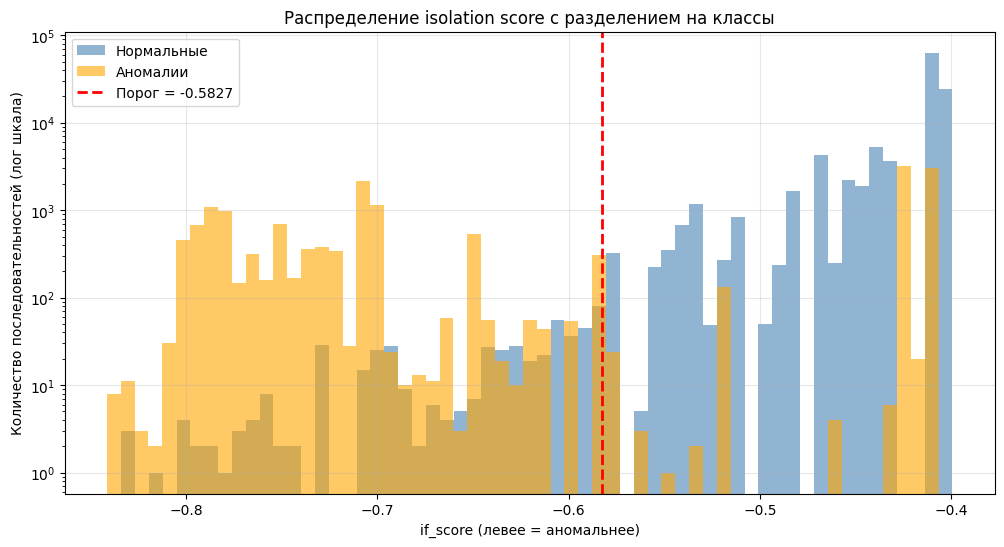

In [43]:
import matplotlib.pyplot as plt
import numpy as np

scores = df_eval["if_score"]
labels = df_eval["true_label"]  # 1 = anomaly, 0 = normal

plt.figure(figsize=(12, 6))

# нормальные
plt.hist(scores[labels == 0], bins=60, alpha=0.6,
         label="Нормальные", color="steelblue")

# аномалии
plt.hist(scores[labels == 1], bins=60, alpha=0.6,
         label="Аномалии", color="orange")

# порог
plt.axvline(best_thr, color="red", linestyle="--", linewidth=2,
            label=f"Порог = {best_thr:.4f}")

plt.yscale("log")  # логарифмическая шкала
plt.xlabel("if_score (левее = аномальнее)")
plt.ylabel("Количество последовательностей (лог шкала)")
plt.title("Распределение isolation score с разделением на классы")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

На гистограмме isolation score заметно, что нормальные последовательности (синие) имеют в основном положительные значения score и формируют плотный пик справа. Аномалии (оранжевые) сконцентрированы в области отрицательных и малых положительных значений, образуя “хвост” распределения слева.

Выбранный порог -0.58 хорошо разделяет две группы, что подтверждается высокими значениями precision = 0.9540 и recall = 0.6165. Логарифмическая шкала по оси Y позволяет визуализировать редкие аномальные последовательности на фоне значительно более частых нормальных.

## Сохранение модели для FastAPI

In [44]:

import joblib
from pathlib import Path

# Путь для сохранения моделей
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

# Сохраняем всё необходимое для inference
artifacts = {
    "model": iso,
    "vectorizer": vectorizer,
    "threshold": best_thr,
    "seed": SEED,
}

joblib.dump(artifacts, MODEL_DIR / "isolation_forest.joblib")

print(f"Модель сохранена в {MODEL_DIR / 'isolation_forest.joblib'}")
print(f"Порог: {best_thr:.6f}")

Модель сохранена в models/isolation_forest.joblib
Порог: -0.582703
